# Visualization from standard shared test set

## Params to edit

In [2]:
modelFN = "model_states/keras__all_hrTarget02_58PM_April_11_2017_bestValidScore"
endoFeatures = ["heart_rate", "new_workout", "gender", "sport", "userId", "altitude", "distance", "derived_speed", "time_elapsed"]
targetAtts = ["heart_rate"]

dpIndex = 201276
plotTitle = "Predicting heart rate using all of the variables"

### Import all the necessary stuff

In [3]:
#Load a saved model and predict some stuff from the validation set

%matplotlib inline
from __future__ import print_function
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.layers.core import Reshape
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys

import keras
from keras.models import load_model

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from data_interpreter_Keras_multiTarget import dataInterpreter, metaDataEndomondo
from inputManager import inputManager
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
import pandas as pd

zMultiple = 5

trimmed_workout_len = 450
num_steps = 128
batch_size_m = 64

data_path = "../multimodalDBM/endomondoHR_proper_newmeta.json"
#data_path = "../multimodalDBM/endomondoHR_proper_newmeta.json"
trainValTestSplit = [0.8, 0.1, 0.1]
trainValTestFN = "logs/keras/keras__noSport_hrTarget" #The filename root from which to load the train valid test split


#endoFeatures = ["heart_rate", "new_workout", "gender", "sport", "userId", "altitude", "distance", "derived_speed", "time_elapsed"] #, "mean_speed", "mean_hr", "total_time"]

#inputOrderNames = [x for x in endoFeatures if x!=targetAtt]
endo_reader = dataInterpreter(fn=data_path, scaleVals=True, trimmed_workout_length=trimmed_workout_len, scaleTargets=True)
endo_reader.buildDataSchema(endoFeatures, targetAtts, trainValTestSplit, zMultiple=zMultiple, trainValidTestFN = trainValTestFN)

input_dim = endo_reader.getInputDim(targetAtts)
target_dim = endo_reader.getTargetDim(targetAtts)


#model = load_model("model_states/no_user_keras_test_epoch_16")
#model = load_model("model_states/keras__all08_06PM_March_19_2017_bestValidScore")
#model = load_model(modelFN)
#keras__all08_06PM_March_19_2017_epoch_20

new_batch_size = 1
new_num_steps = trimmed_workout_len

oldModel = keras.models.load_model(modelFN)#Load a model that has already been trained

print('Rebuild model with new batch size...')
model = Sequential()
#model.add(Reshape((batch_size_m, num_steps, input_dim), batch_input_shape=(batch_size_m*num_steps, input_dim)))
model.add(LSTM(128, return_sequences=True, batch_input_shape=(new_batch_size, new_num_steps, input_dim), stateful=True))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True, stateful=True))
model.add(Dropout(0.2))
model.add(Dense(target_dim))
model.add(Activation('linear'))

model.compile(loss='mean_squared_error', optimizer='rmsprop')

model.set_weights(oldModel.get_weights())#Transfer the weights from the old model to the new model
print("Endomodel Built!")

def rescaleZscoredData(endo_reader, sequence, att, zMultiple):
    #Removes the z score scaling. Does this by getting the varmeans and stds from the endo_reader, 
    #and then performing arithmetic operations on the data sequence
        
    variableMeans = endo_reader.variableMeans
    variableStds = endo_reader.variableStds
    
    unMult = [x/float(zMultiple) for x in sequence]
    diff = [x*float(variableStds[att]) for x in unMult]
    raw = [x+float(variableMeans[att]) for x in diff]
    return raw

def getInputByName(input_data, varName, endoReader):
    #Provides access to decoded input variable sequences by attribute name
    dataKey = endoReader.decoderKey()
    dataIndex = dataKey.index(varName)
    batch_size = np.shape(input_data)[0]
    varData = []
    for i in range(batch_size):
        decodedData = np.array(endoReader.dataDecoder(input_data[i]))
        #print(np.shape(decodedData))
        varData.extend(decodedData[:, dataIndex])
    return varData

Using TensorFlow backend.


Loading metadata
Metadata loaded
Rebuild model with new batch size...
Endomodel Built!


### Make predictions

In [7]:
testIndex += 1
dpIndex = test_set[testIndex]
print(dpIndex)

#pred_gen = endo_reader.endoIteratorSupervised(batch_size_m, num_steps, "test")
pred_inputs, pred_targets = endo_reader.getDpByIndex(dpIndex, scaling=True)

predictions = model.predict_on_batch(pred_inputs)
print("Done Predicting!")

70278
Done Predicting!


### Plot the predictions vs the targets

In [4]:
target_att = targetAtts[0]
scaled_predictions = rescaleZscoredData(endo_reader, predictions.flatten(), target_att, zMultiple)
scaled_pred_targets = rescaleZscoredData(endo_reader, pred_targets.flatten(), target_att, zMultiple)
#indices=np.array(range(trimmed_workout_len))
input_att = "time_elapsed"
unscaledInputSeq = np.array(getInputByName(pred_inputs, input_att, endo_reader)).astype(np.float)
time_in_seconds = rescaleZscoredData(endo_reader, unscaledInputSeq, input_att, zMultiple)
time_in_minutes = [x/60.0 for x in time_in_seconds]

% config InlineBackend.figure_format = 'retina'
plt.figure(num=None, figsize=(15, 10), dpi=200, facecolor='w', edgecolor='k')

# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.) 

# Remove the plot frame lines. They are unnecessary chartjunk.    
ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)    
  
# Ensure that the axis ticks only show up on the bottom and left of the plot.    
# Ticks on the right and top of the plot are generally unnecessary chartjunk.    
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()   

y_major_tics = ax.get_yaxis().get_major_ticks()

#for y in y_major_tics:    
#    plt.plot(range(0, 450), [y] * len(range(0, 450)), "--", lw=0.5, color="black", alpha=0.3)    

plt.minorticks_on()
plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on")   
  
# Limit the range of the plot to only where the data is.    
# Avoid unnecessary whitespace.    
#plt.ylim(0, 90)    
#plt.xlim(1968, 2014)

# Make sure your axis ticks are large enough to be easily read.    
# You don't want your viewers squinting to read your plot.    
plt.yticks(fontsize=14)    
plt.xticks(fontsize=14)   
plt.grid(b=True, which='major', color="black", alpha=0.3, linestyle='-')
plt.grid(b=True, which='minor', color="black", alpha=0.1, linestyle='-')

plt.plot(time_in_minutes, scaled_predictions, lw=2.5, color=tableau20[0])
plt.plot(time_in_minutes, scaled_pred_targets, lw=2.5, color=tableau20[2])

plt.xlim(0, np.max(time_in_minutes))
minY = min([min(scaled_predictions),min(scaled_pred_targets)])
maxY = max([max(scaled_predictions),max(scaled_pred_targets)])
plt.ylim(minY-5, maxY+5)
#print(maxY)

#plt.suptitle("Model predictions: Red   Targets: Blue")
#plt.title("Predicting heart rate using all of the variables except the sport", fontsize=16)

plt.text(max(time_in_minutes)/2, maxY+10, plotTitle, fontsize=17, ha="center")

plt.text(max(time_in_minutes), minY+10, "Model predictions", fontsize=14, ha="right", color=tableau20[0])  
plt.text(max(time_in_minutes), minY+15, "Actual measurement", fontsize=14, ha="right", color=tableau20[2])  

plt.xlabel('Minutes', fontsize=14)
plt.ylabel('Heart Rate', fontsize=14)
plt.show()

dpInfo = endo_reader.getDpInfo(dpIndex, format="pandas")
print("\nWorkout URL: " + dpInfo['url'][0])
print("Sport: " + dpInfo['sport'][0])

NameError: name 'predictions' is not defined

In [6]:
#Get test set list
test_set = endo_reader.testSet
test_set[8]

201276

In [51]:
#Get dp info
dpInfo = endo_reader.getDpInfo(dpIndex, format="pandas")
#dpInfo['url'][0]
dpInfo

,altitude,gender,heart_rate,id,latitude,longitude,sport,timestamp,url,userId
0,10.8,male,95,274426889,59.381579,17.967767,run,1386119844,https://www.endomondo.com/users/407769/workout...,407769
1,10.8,male,97,274426889,59.381704,17.967664,run,1386119849,https://www.endomondo.com/users/407769/workout...,407769
2,10.8,male,102,274426889,59.381747,17.967631,run,1386119851,https://www.endomondo.com/users/407769/workout...,407769
3,10.8,male,103,274426889,59.381825,17.967635,run,1386119855,https://www.endomondo.com/users/407769/workout...,407769
4,10.8,male,107,274426889,59.381874,17.967552,run,1386119858,https://www.endomondo.com/users/407769/workout...,407769
5,10.8,male,114,274426889,59.381942,17.967400,run,1386119862,https://www.endomondo.com/users/407769/workout...,407769
6,10.8,male,114,274426889,59.381973,17.967314,run,1386119864,https://www.endomondo.com/users/407769/workout...,407769
7,10.8,male,120,274426889,59.382030,17.967293,run,1386119867,https://www.endomondo.com/users/407769/workout...,407769
8,10.6,male,130,274426889,59.382085,17.967383,run,1386119870,https://www.endomondo.com/users/407769/workout...,407769
9,10.6,male,129,274426889,59.382123,17.967521,run,1386119873,https://www.endomondo.com/users/407769/workout...,407769


In [60]:
input_att = "time_elapsed"
unscaledInputSeq = np.array(getInputByName(input_att, endo_reader)).astype(np.float)
time_in_seconds = rescaleZscoredData(endo_reader, unscaledInputSeq, input_att, zMultiple)
time_in_minutes = [x/60.0 for x in time_in_seconds]
time_in_minutes

[2.4826173709395029e-10,
 0.083333333255965647,
 0.11666666645905935,
 0.18333333350804726,
 0.2333333333126878,
 0.29999999971884489,
 0.33333333356476941,
 0.38333333336934933,
 0.43333333317395956,
 0.48333333362143094,
 0.65000000027969995,
 0.73333333328737349,
 0.88333333334403508,
 0.96666666635170861,
 1.0666666666037903,
 1.2333333332620593,
 1.4166666665218448,
 1.5999999997815999,
 1.7000000000336513,
 1.8999999998949533,
 2.0666666665531919,
 2.13333333360218,
 2.2666666664144941,
 2.3333333334635125,
 2.4333333330727327,
 2.5666666665278779,
 2.6833333333815061,
 2.749999999787633,
 2.7666666663892103,
 2.8500000000397447,
 2.9500000002918267,
 3.1333333335515516,
 3.2166666665592554,
 3.3166666668113369,
 3.4500000002665123,
 3.5999999996803429,
 3.7499999997370046,
 3.8999999997936965,
 4.0666666664519653,
 4.2666666669560982,
 4.3666666665653491,
 4.4666666668174004,
 4.6500000000771555,
 4.8333333333369408,
 5.0166666665966959,
 5.0833333336457143,
 5.1166666668487775,

## Plot altitude against heart rate

In [14]:
dpIndex = 28199
print(dpIndex)

#pred_gen = endo_reader.endoIteratorSupervised(batch_size_m, num_steps, "test")
pred_inputs, pred_targets = endo_reader.getDpByIndex(dpIndex, scaling=True)

predictions = model.predict_on_batch(pred_inputs)
print("Done Predicting!")

28199
Done Predicting!


Max value for  altitude  is  1029.3
Min value for  altitude  is  372.999999999
Max value for  derived_speed  is  38.053175512
Min value for  derived_speed  is  3.37865893262


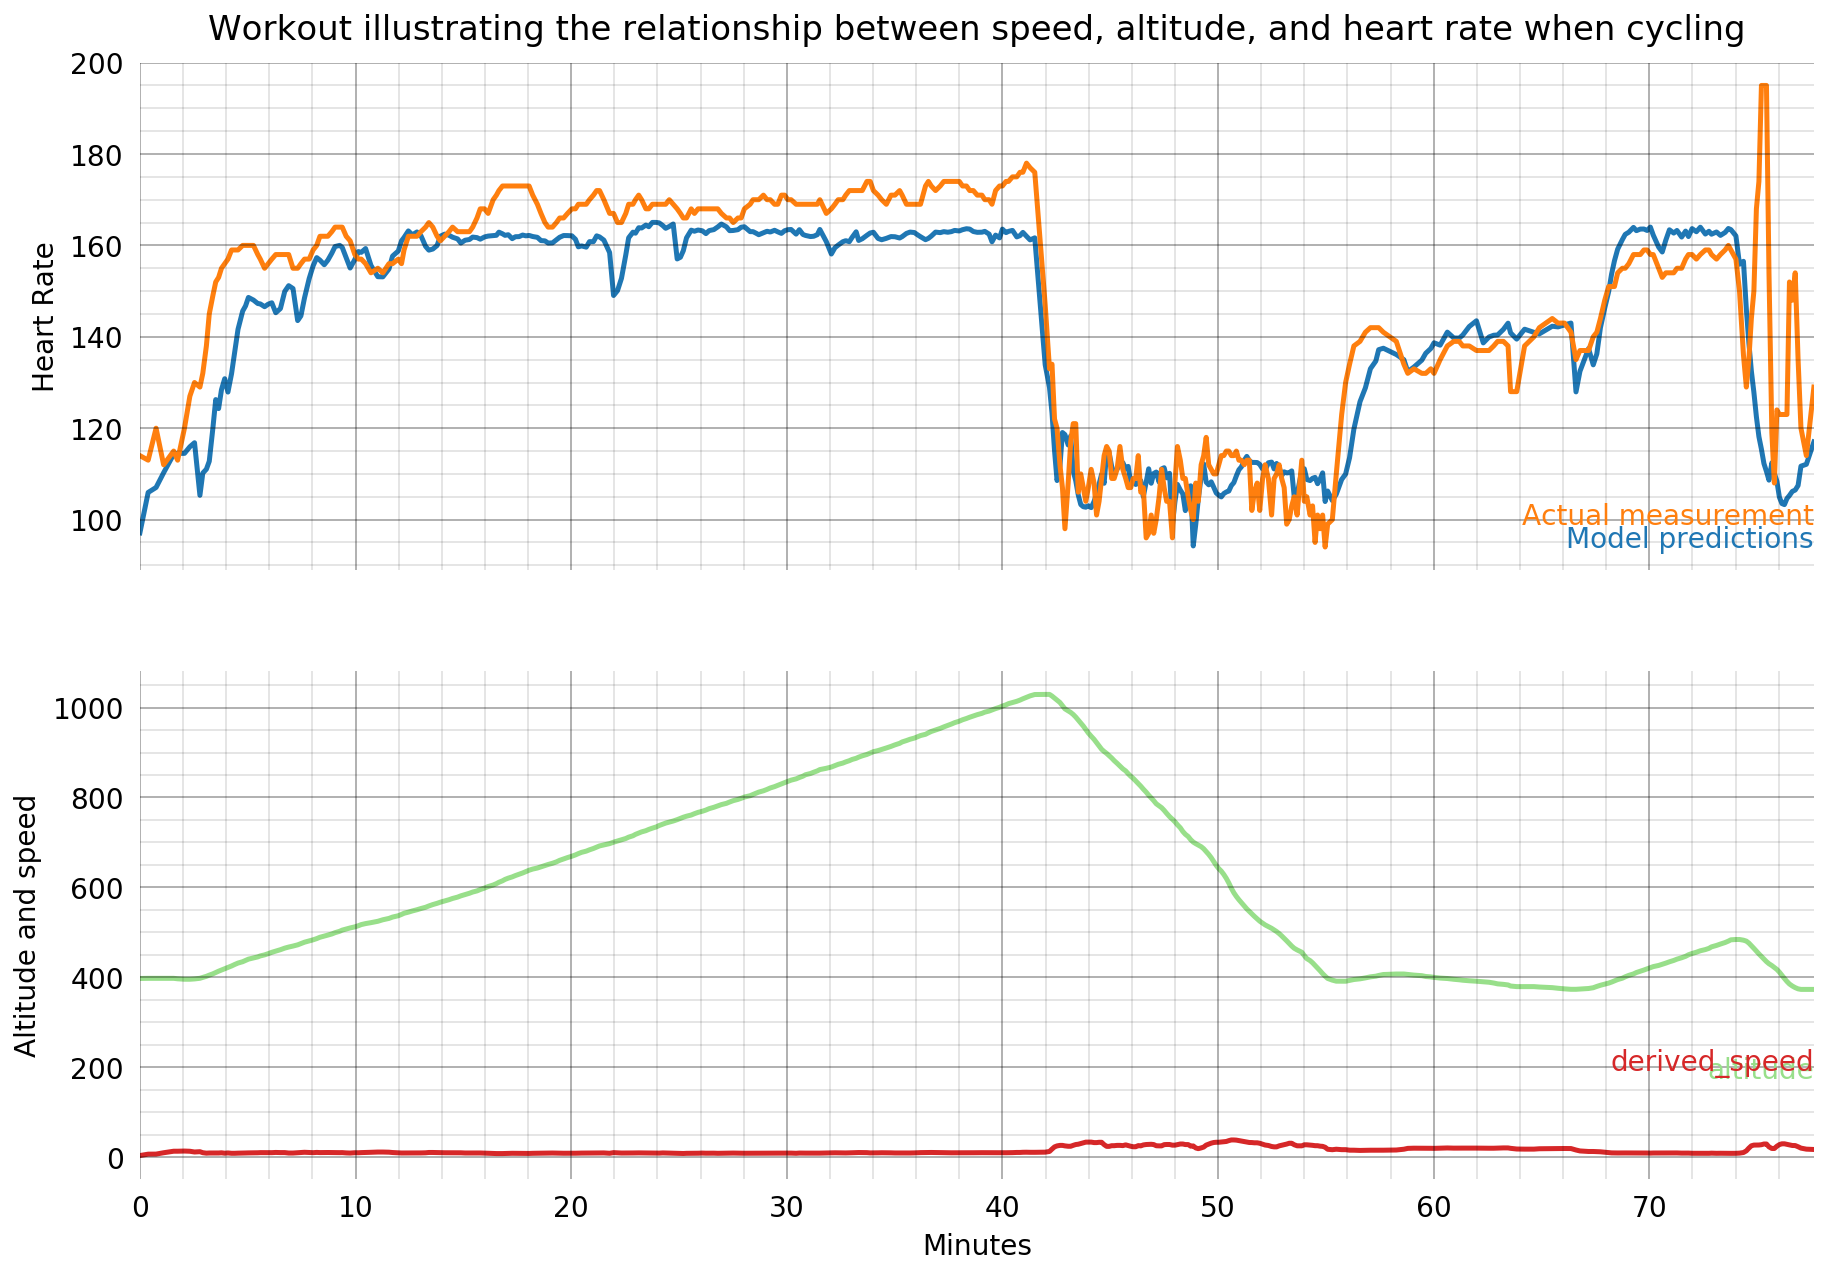

In [18]:
target_att = targetAtts[0]
scaled_predictions = rescaleZscoredData(endo_reader, predictions.flatten(), target_att, zMultiple)
scaled_pred_targets = rescaleZscoredData(endo_reader, pred_targets.flatten(), target_att, zMultiple)
#indices=np.array(range(trimmed_workout_len))

inputAttributes = ['altitude', 'derived_speed']
targetAtt = "heart_rate"
scaleFactors = [1, (3600/1.60934)]
smoothing_factor = 5

attributeInputData=[]
for att in inputAttributes:
    unsmoothed = np.array(getInputByName(pred_inputs, att, endo_reader)).astype(np.float)
    #unsmoothed = np.array(getInputByName(att, endo_reader)).astype(np.float) #OLD VERSION
    scaled = rescaleZscoredData(endo_reader, unsmoothed, att, zMultiple)
    attributeInputData.append(endo_reader.median_smoothing(scaled, smoothing_factor))
    

input_att = "time_elapsed"
unscaledInputSeq = np.array(getInputByName(pred_inputs, input_att, endo_reader)).astype(np.float)
time_in_seconds = rescaleZscoredData(endo_reader, unscaledInputSeq, input_att, zMultiple)
time_in_minutes = [x/60.0 for x in time_in_seconds]



% config InlineBackend.figure_format = 'retina'
plt.figure(num=None, figsize=(15, 10), dpi=200, facecolor='w', edgecolor='k')

# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.) 

# Remove the plot frame lines. They are unnecessary chartjunk.
plt.subplot(211)
ax1 = plt.subplot(211)    
ax1.spines["top"].set_visible(False)    
ax1.spines["bottom"].set_visible(False)    
ax1.spines["right"].set_visible(False)    
ax1.spines["left"].set_visible(False)    
  
# Ensure that the axis ticks only show up on the bottom and left of the plot.    
# Ticks on the right and top of the plot are generally unnecessary chartjunk.    
ax1.get_xaxis().tick_bottom()    
ax1.get_yaxis().tick_left()   

y_major_tics = ax1.get_yaxis().get_major_ticks()

#for y in y_major_tics:    
#    plt.plot(range(0, 450), [y] * len(range(0, 450)), "--", lw=0.5, color="black", alpha=0.3)    

plt.minorticks_on()
plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="off", left="off", right="off", labelleft="on")   
  
# Limit the range of the plot to only where the data is.    
# Avoid unnecessary whitespace.    
#plt.ylim(0, 90)    
#plt.xlim(1968, 2014)

# Make sure your axis ticks are large enough to be easily read.    
# You don't want your viewers squinting to read your plot.    
plt.yticks(fontsize=14)    
plt.xticks(fontsize=14)   
plt.grid(b=True, which='major', color="black", alpha=0.3, linestyle='-')
plt.grid(b=True, which='minor', color="black", alpha=0.1, linestyle='-')

plt.plot(time_in_minutes, scaled_predictions, lw=2.5, color=tableau20[0])
plt.plot(time_in_minutes, scaled_pred_targets, lw=2.5, color=tableau20[2])

plt.xlim(0, np.max(time_in_minutes))
minY = min([min(scaled_predictions),min(scaled_pred_targets)])
maxY = max([max(scaled_predictions),max(scaled_pred_targets)])
plt.ylim(minY-5, maxY+5)
#print(maxY)

#plt.suptitle("Model predictions: Red   Targets: Blue")
#plt.title("Predicting heart rate using all of the variables except the sport", fontsize=16)

plt.text(max(time_in_minutes)/2, maxY+10, "Workout illustrating the relationship between speed, altitude, and heart rate when cycling", fontsize=17, ha="center")

plt.text(max(time_in_minutes), minY+0, "Model predictions", fontsize=14, ha="right", color=tableau20[0])  
plt.text(max(time_in_minutes), minY+5, "Actual measurement", fontsize=14, ha="right", color=tableau20[2])  

#plt.xlabel('Minutes', fontsize=14)
plt.ylabel('Heart Rate', fontsize=14)


#New figure
#plt.figure(num=None, figsize=(15, 10), dpi=200, facecolor='w', edgecolor='k')


plt.subplot(212)
ax2 = plt.subplot(212, sharex=ax1)    
ax2.spines["top"].set_visible(False)    
ax2.spines["bottom"].set_visible(False)    
ax2.spines["right"].set_visible(False)    
ax2.spines["left"].set_visible(False) 

ax2.get_xaxis().tick_bottom()    
ax2.get_yaxis().tick_left()   

y_major_tics = ax2.get_yaxis().get_major_ticks()

plt.minorticks_on()
plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on") 

plt.yticks(fontsize=14)    
plt.xticks(fontsize=14)   
plt.grid(b=True, which='major', color="black", alpha=0.3, linestyle='-')
plt.grid(b=True, which='minor', color="black", alpha=0.1, linestyle='-')

colorIndex = 5
for i, att in enumerate(inputAttributes):
    currentAttInputData = attributeInputData[i]
    scaled_currentAttInputData = [x * scaleFactors[i] for x in currentAttInputData]
    plt.plot(time_in_minutes, scaled_currentAttInputData, lw=2.5, color = tableau20[colorIndex])
    plt.text(max(time_in_minutes), minY+80+i*20, att, fontsize=14, ha="right", color=tableau20[colorIndex])
    colorIndex += 1

    print("Max value for ", inputAttributes[i], " is ", max(scaled_currentAttInputData))
    print("Min value for ", inputAttributes[i], " is ", min(scaled_currentAttInputData))
    #title = title + " " + inputAttributes[i]
    
plt.xlim(0, np.max(time_in_minutes))


plt.xlabel('Minutes', fontsize=14)
plt.ylabel('Altitude and speed', fontsize=14)

plt.show()


#dpInfo = endo_reader.getDpInfo(dpIndex, format="pandas")
#print("\nWorkout URL: " + dpInfo['url'][0])
#print("Sport: " + dpInfo['sport'][0])

## Relationship between altitude, hr, and speed for running

In [5]:
dpIndex = 191470 #28199
print(dpIndex)

#pred_gen = endo_reader.endoIteratorSupervised(batch_size_m, num_steps, "test")
pred_inputs, pred_targets = endo_reader.getDpByIndex(dpIndex, scaling=True)

predictions = model.predict_on_batch(pred_inputs)
print("Done Predicting!")

191470
Done Predicting!


Max value for  altitude  is  1029.3
Min value for  altitude  is  372.999999999
Max value for  derived_speed  is  38.053175512
Min value for  derived_speed  is  3.37865893262


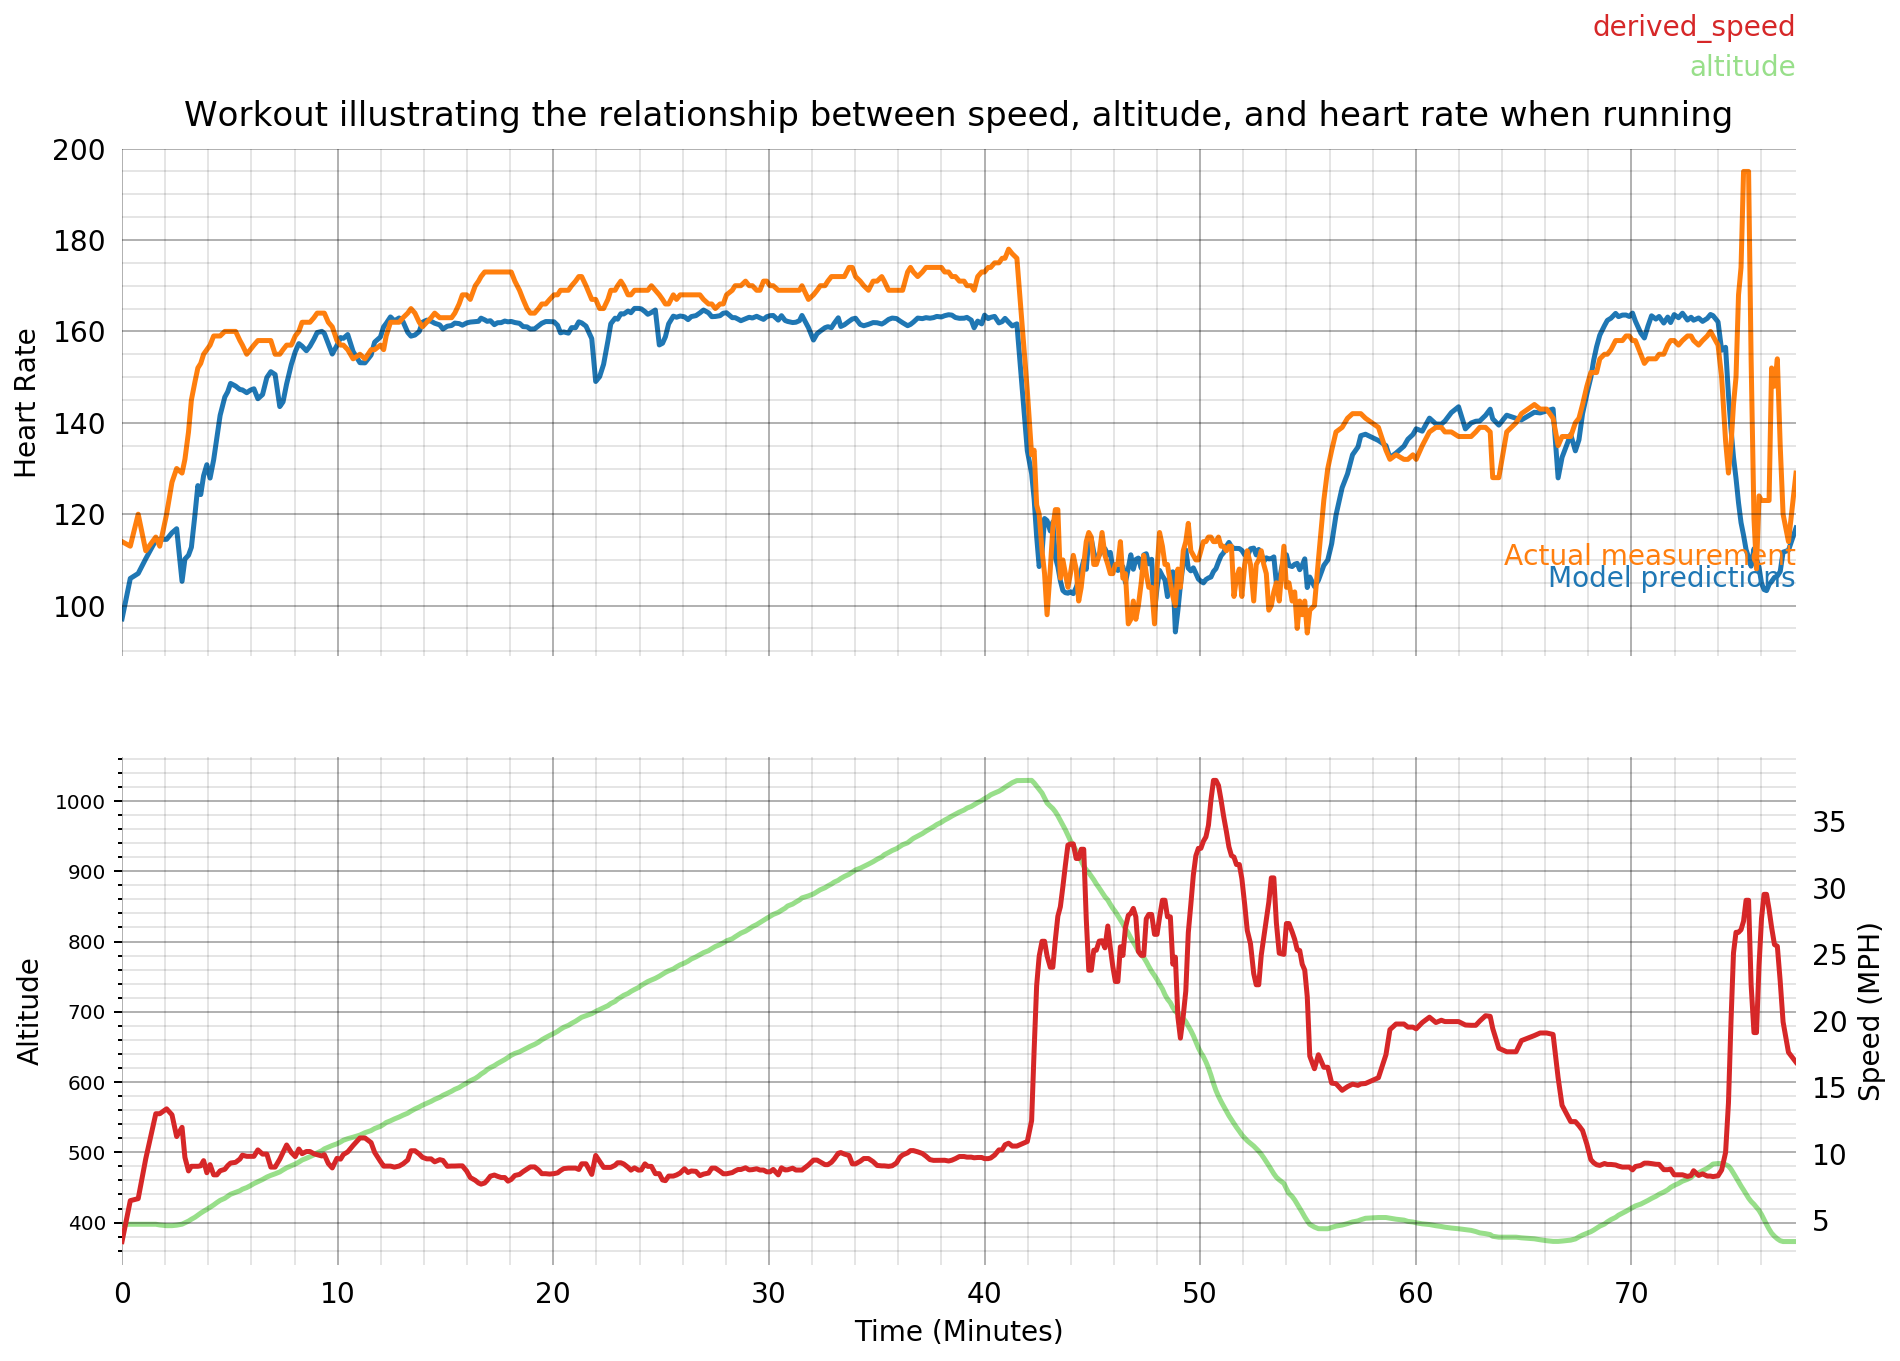

In [33]:
target_att = targetAtts[0]
scaled_predictions = rescaleZscoredData(endo_reader, predictions.flatten(), target_att, zMultiple)
scaled_pred_targets = rescaleZscoredData(endo_reader, pred_targets.flatten(), target_att, zMultiple)
#indices=np.array(range(trimmed_workout_len))

inputAttributes = ['altitude', 'derived_speed']
targetAtt = "heart_rate"
scaleFactors = [1, (3600/1.60934)]#[pow(10,20)*4, 2000]
additiveScaleFactors = [0, 0]#[pow(10,20)*4, 2000]

smoothing_factor = 5

attributeInputData=[]
for att in inputAttributes:
    #unsmoothed = np.array(getInputByName(pred_inputs, att, endo_reader)).astype(np.float)
    unsmoothed = np.array(getInputByName(pred_inputs, att, endo_reader)).astype(np.float) #OLD VERSION
    scaled = rescaleZscoredData(endo_reader, unsmoothed, att, zMultiple)
    attributeInputData.append(endo_reader.median_smoothing(scaled, smoothing_factor))
    

input_att = "time_elapsed"
unscaledInputSeq = np.array(getInputByName(pred_inputs, input_att, endo_reader)).astype(np.float)
time_in_seconds = rescaleZscoredData(endo_reader, unscaledInputSeq, input_att, zMultiple)
time_in_minutes = [x/60.0 for x in time_in_seconds]



% config InlineBackend.figure_format = 'retina'
plt.figure(num=None, figsize=(15, 10), dpi=200, facecolor='w', edgecolor='k')

# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.) 

# Remove the plot frame lines. They are unnecessary chartjunk.
plt.subplot(211)
ax1 = plt.subplot(211)    
ax1.spines["top"].set_visible(False)    
ax1.spines["bottom"].set_visible(False)    
ax1.spines["right"].set_visible(False)    
ax1.spines["left"].set_visible(False)    
  
# Ensure that the axis ticks only show up on the bottom and left of the plot.    
# Ticks on the right and top of the plot are generally unnecessary chartjunk.    
ax1.get_xaxis().tick_bottom()    
ax1.get_yaxis().tick_left()   

y_major_tics = ax1.get_yaxis().get_major_ticks()

#for y in y_major_tics:    
#    plt.plot(range(0, 450), [y] * len(range(0, 450)), "--", lw=0.5, color="black", alpha=0.3)    

plt.minorticks_on()
plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="off", left="off", right="off", labelleft="on")   
  
# Limit the range of the plot to only where the data is.    
# Avoid unnecessary whitespace.    
#plt.ylim(0, 90)    
#plt.xlim(1968, 2014)

# Make sure your axis ticks are large enough to be easily read.    
# You don't want your viewers squinting to read your plot.    
plt.yticks(fontsize=14)    
plt.xticks(fontsize=14)   
plt.grid(b=True, which='major', color="black", alpha=0.3, linestyle='-')
plt.grid(b=True, which='minor', color="black", alpha=0.1, linestyle='-')

plt.plot(time_in_minutes, scaled_predictions, lw=2.5, color=tableau20[0])
plt.plot(time_in_minutes, scaled_pred_targets, lw=2.5, color=tableau20[2])

plt.xlim(0, np.max(time_in_minutes))
minY = min([min(scaled_predictions),min(scaled_pred_targets)])
maxY = max([max(scaled_predictions),max(scaled_pred_targets)])
plt.ylim(minY-5, maxY+5)
#print(maxY)

#plt.suptitle("Model predictions: Red   Targets: Blue")
#plt.title("Predicting heart rate using all of the variables except the sport", fontsize=16)

plt.text(max(time_in_minutes)/2, maxY+10, "Workout illustrating the relationship between speed, altitude, and heart rate when running", fontsize=17, ha="center")

plt.text(max(time_in_minutes), minY+10, "Model predictions", fontsize=14, ha="right", color=tableau20[0])  
plt.text(max(time_in_minutes), minY+15, "Actual measurement", fontsize=14, ha="right", color=tableau20[2])  

#plt.xlabel('Minutes', fontsize=14)
plt.ylabel('Heart Rate', fontsize=14)


#New figure
#plt.figure(num=None, figsize=(15, 10), dpi=200, facecolor='w', edgecolor='k')


plt.subplot(212)
ax2 = plt.subplot(212, sharex=ax1)    
ax2.spines["top"].set_visible(False)    
ax2.spines["bottom"].set_visible(False)    
ax2.spines["right"].set_visible(False)    
ax2.spines["left"].set_visible(False) 

#ax2.get_xaxis().tick_bottom()    
#ax2.get_yaxis().tick_left()
plt.ylabel('Altitude', fontsize=14)
plt.xlabel('Time (Minutes)', fontsize=14)


plt.minorticks_on()
plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="off") 

plt.yticks(fontsize=14)    
plt.xticks(fontsize=14)   
plt.grid(b=True, which='major', color="black", alpha=0.3, linestyle='-')
plt.grid(b=True, which='minor', color="black", alpha=0.1, linestyle='-')

#y_major_tics = ax2.get_yaxis().get_major_ticks()


ax3 = ax2.twinx()
ax3.spines["top"].set_visible(False)    
ax3.spines["bottom"].set_visible(False)    
ax3.spines["right"].set_visible(False)    
ax3.spines["left"].set_visible(False) 



#plt.minorticks_on()
plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="off") 

plt.yticks(fontsize=14)    
plt.xticks(fontsize=14)   
#plt.grid(b=True, which='major', color="black", alpha=0.3, linestyle='-')
#plt.grid(b=True, which='minor', color="black", alpha=0.1, linestyle='-')

colorIndex = 5
for i, att in enumerate(inputAttributes):
    currentAttInputData = attributeInputData[i]
    scaled_currentAttInputData = [x * scaleFactors[i] + additiveScaleFactors[i] for x in currentAttInputData]
    if i==0:
        ax2.plot(time_in_minutes, scaled_currentAttInputData, lw=2.5, color = tableau20[colorIndex])
    elif i==1:
        ax3.plot(time_in_minutes, scaled_currentAttInputData, lw=2.5, color = tableau20[colorIndex])
    else:
        raise(exception("Need to add handling of more input vars"))
    plt.text(max(time_in_minutes), minY-3+i*3, att, fontsize=14, ha="right", color=tableau20[colorIndex])  

    colorIndex += 1
    print("Max value for ", inputAttributes[i], " is ", max(scaled_currentAttInputData))
    print("Min value for ", inputAttributes[i], " is ", min(scaled_currentAttInputData))
    #title = title + " " + inputAttributes[i]
    
plt.xlim(0, np.max(time_in_minutes))
#plt.ylim(0, 110)

#plt.xlabel('Minutes', fontsize=14)
plt.ylabel('Speed (MPH)', fontsize=14)


plt.show()


#dpInfo = endo_reader.getDpInfo(dpIndex, format="pandas")
#print("\nWorkout URL: " + dpInfo['url'][0])
#print("Sport: " + dpInfo['sport'][0])

In [7]:
variableMeans = endo_reader.variableMeans
variableStds = endo_reader.variableStds

#unMult = [x/float(zMultiple) for x in sequence]
#diff = [x*float(variableStds[att]) for x in unMult]
#raw = [x+float(variableMeans[att]) for x in diff]
print(variableMeans["derived_speed"])
print(variableStds["derived_speed"])

0.00358659354261
0.60526501872


In [10]:
def getInputByName(input_data, varName, endoReader):
    #Provides access to decoded input variable sequences by attribute name
    dataKey = endoReader.decoderKey()
    dataIndex = dataKey.index(varName)
    batch_size = np.shape(pred_inputs)[0]
    varData = []
    for i in range(batch_size):
        decodedData = np.array(endoReader.dataDecoder(input_data[i]))
        #print(np.shape(decodedData))
        varData.extend(decodedData[:, dataIndex])
    return varData
getInputByName(pred_inputs, "altitude", endo_reader)

array([[[  1.11746397e+02,   0.00000000e+00,   1.00000000e+00, ...,
          -7.82011035e-02,  -2.96282903e-02,  -3.15141091e-02],
        [ -1.59801804e-01,   0.00000000e+00,   1.00000000e+00, ...,
          -5.72482643e-02,  -6.84596855e-03,  -3.15037387e-02],
        [ -1.59801804e-01,   0.00000000e+00,   1.00000000e+00, ...,
          -3.35972776e-02,  -5.37910140e-03,  -3.14829978e-02],
        ..., 
        [ -1.59801804e-01,   0.00000000e+00,   1.00000000e+00, ...,
          -2.84239937e-02,  -2.56660859e-03,  -2.17788810e-02],
        [ -1.59801804e-01,   0.00000000e+00,   1.00000000e+00, ...,
          -5.32331567e-02,  -2.48028462e-03,  -2.17685106e-02],
        [ -1.59801804e-01,   0.00000000e+00,   1.00000000e+00, ...,
          -5.83229885e-02,  -8.09945288e-04,  -2.17607328e-02]]])